Project root on sys.path: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS
PV CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/generation/latest.csv
Market CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/market/latest.csv
Charging Strategy: Generation
Strategy Status: Active

Verwendetes Szenario: office
Ladepunkte: 5
Zeitraum: 2025-03-04 00:00:00 bis 2025-03-23 23:45:00
Horizont: 20 Tage

Sessions
Ankünfte mit Ladebedarf: 283
mit Ladezugang: 115
ohne Ladezugang (drive_off): 168
Ziel-SoC nicht erreicht: 2


,session_id,vehicle_name,charger_id,remaining_energy_kwh,state_of_charge_at_arrival,state_of_charge_end
0,2025-03-13_009_00014,Porsche Taycan,3,26.257416,0.130028,0.667662
1,2025-03-07_003_00011,Polestar 2 LR DM,3,1.228517,0.259030,0.934250


Daytypes: {'working_day': 14, 'saturday': 3, 'sunday_holiday': 3}


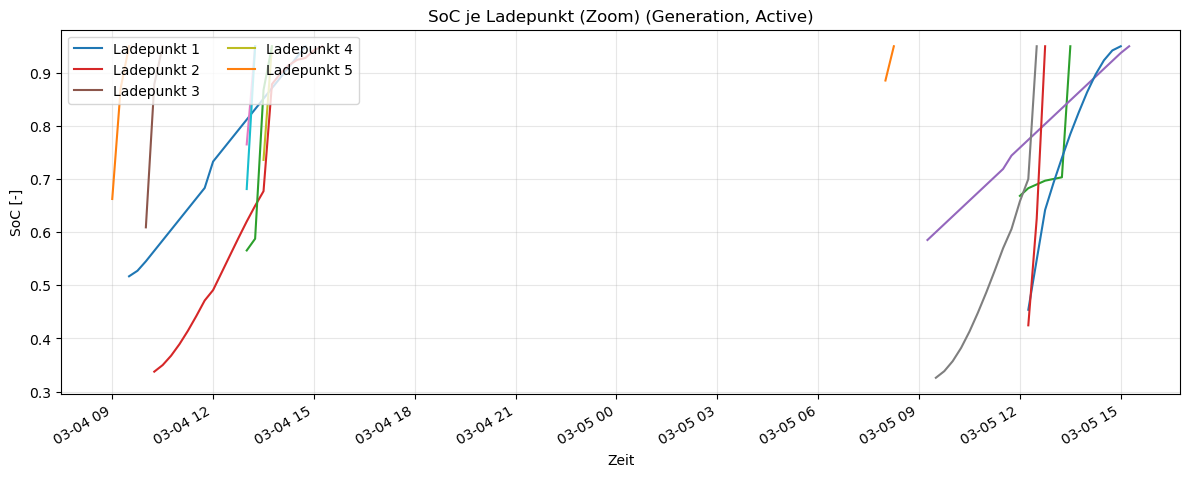

Überschreitungen: 7


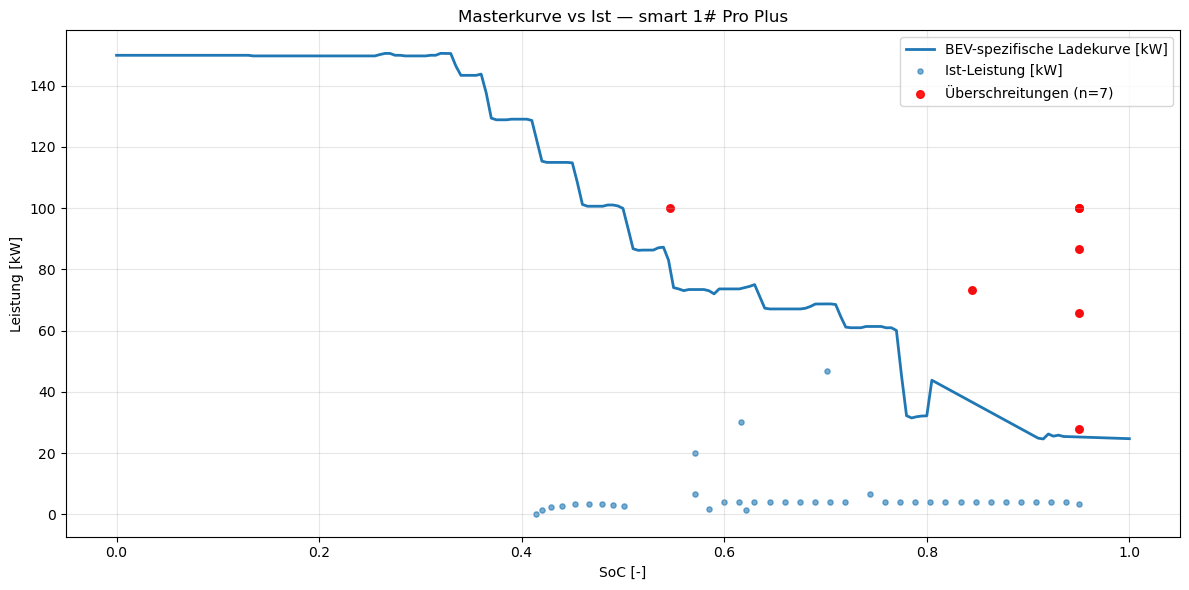

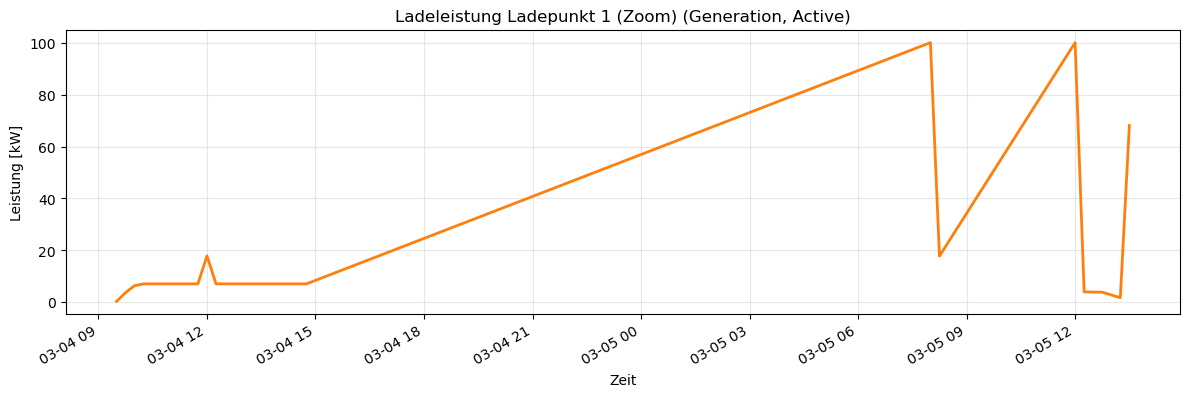

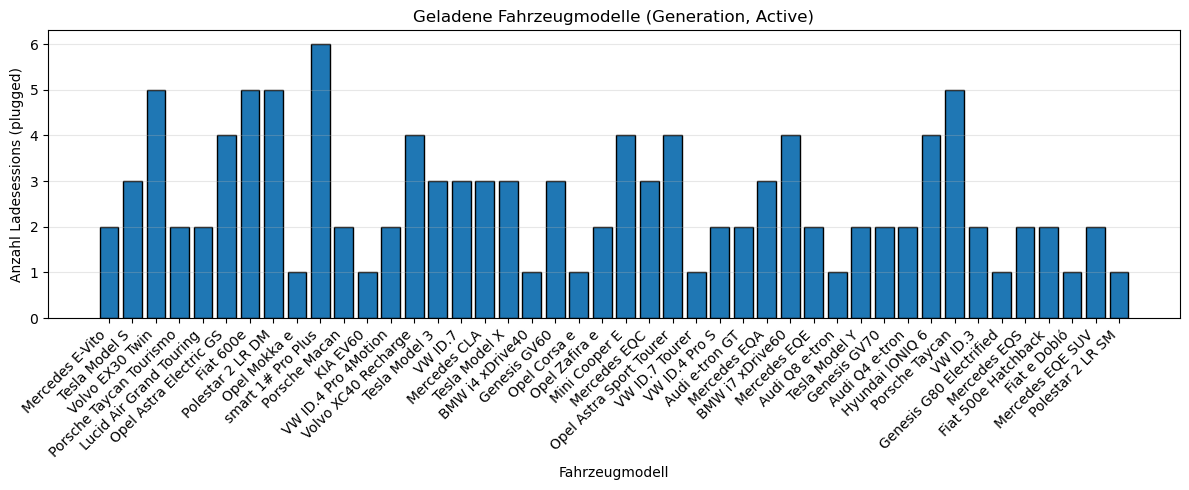

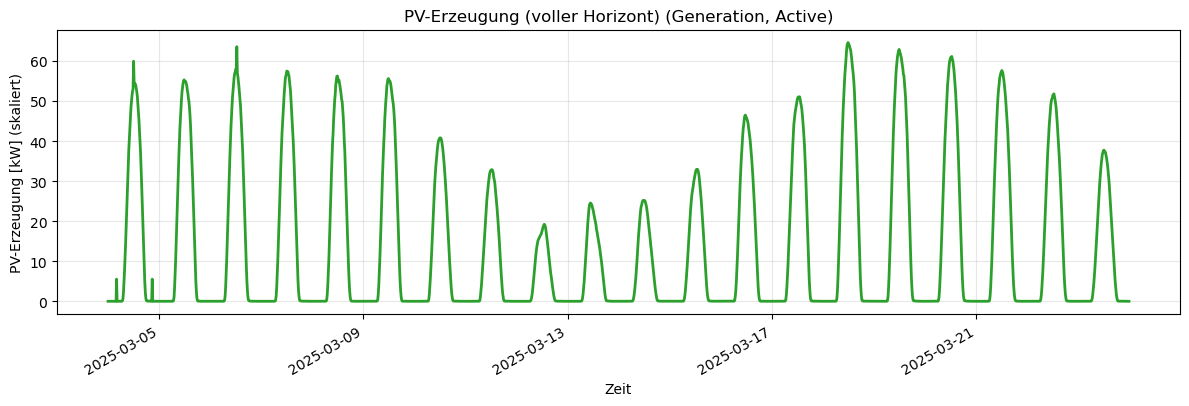

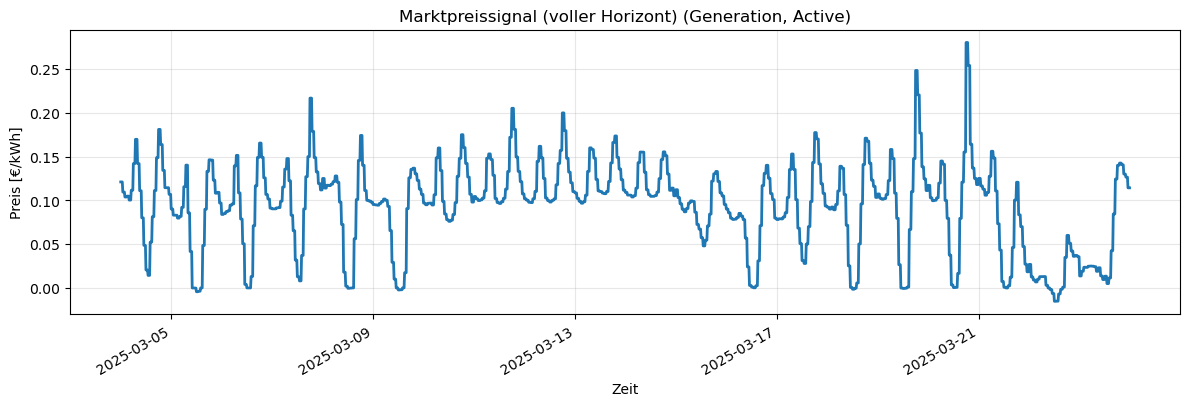

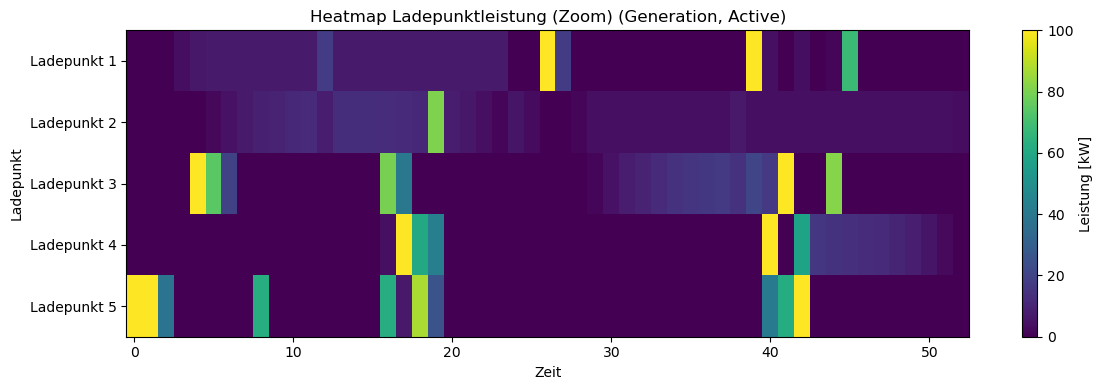

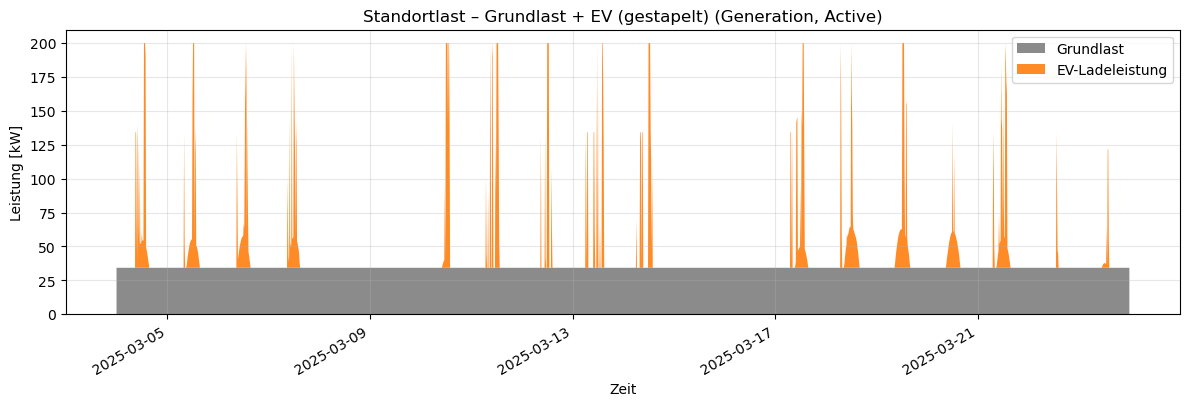

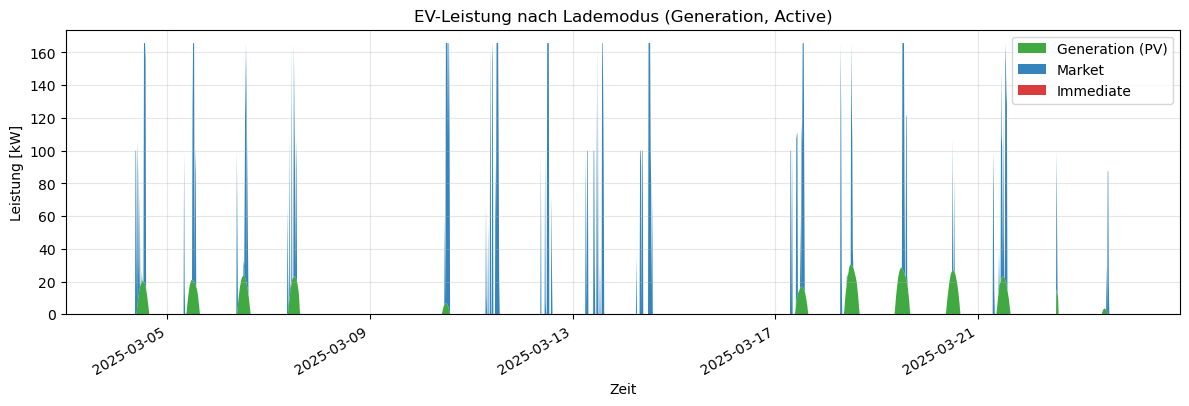

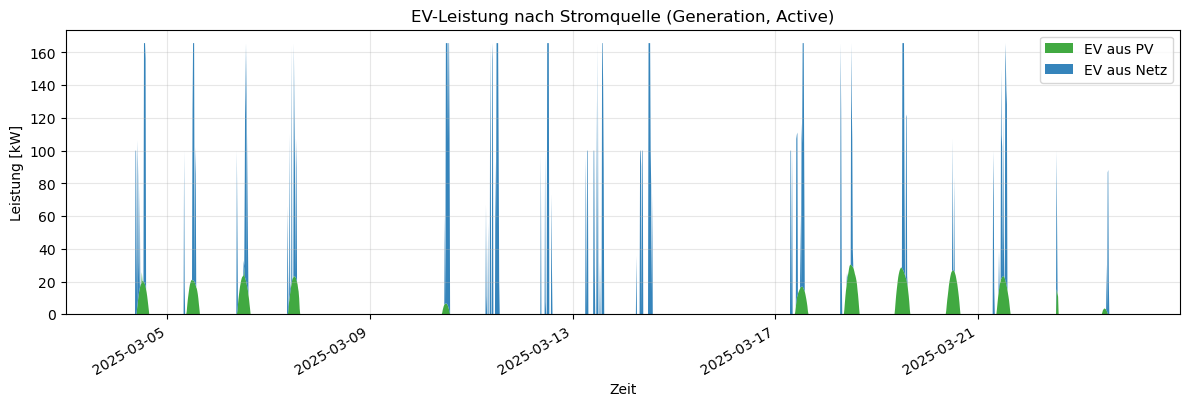

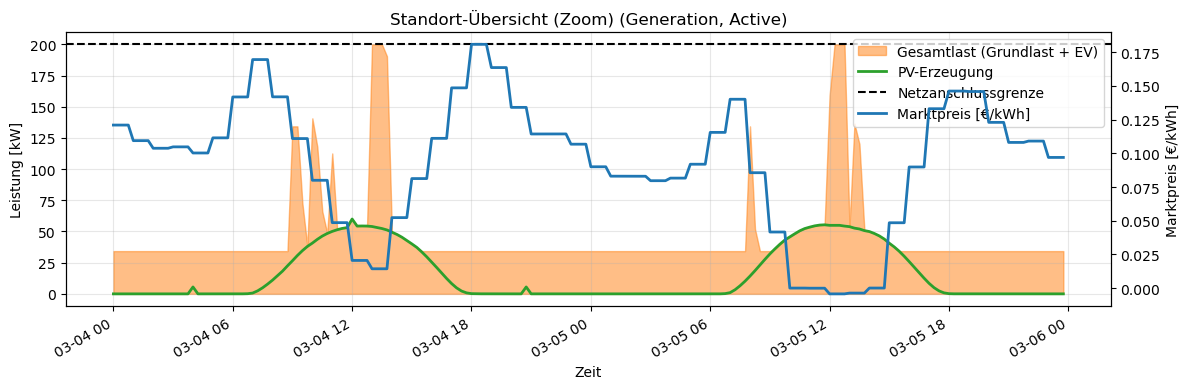

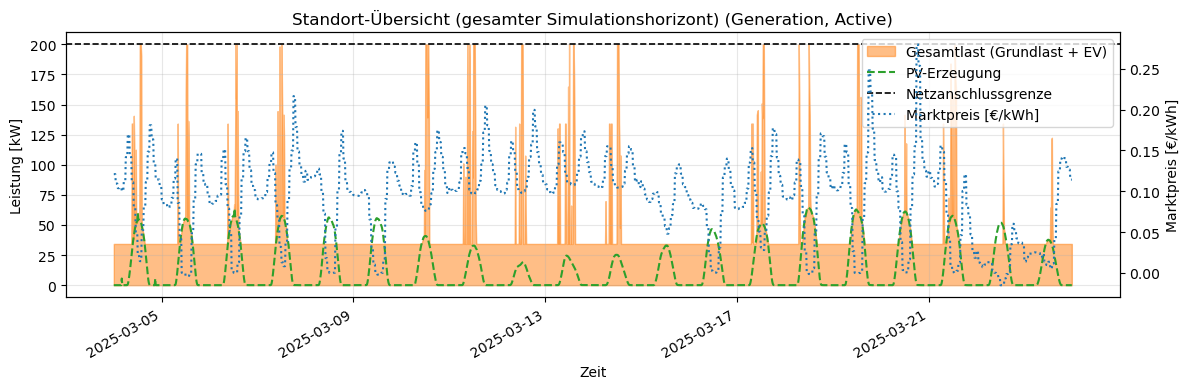

,session_id,charger_id,vehicle_name,arrival_time,departure_time,state_of_charge_at_arrival,state_of_charge_end,charged_site_kwh,charged_pv_site_kwh,charged_market_site_kwh,charged_immediate_site_kwh,remaining_site_kwh
0,2025-03-04_000_00017,0,Mercedes E-Vito,2025-03-04 07:45:00,2025-03-04 15:00:00,0.515943,0.95,39.065098,39.065098,0.000000,0.0,0.0
1,2025-03-04_000_00007,1,Tesla Model S,2025-03-04 08:00:00,2025-03-04 17:30:00,0.331626,0.95,61.837409,44.168515,17.668894,0.0,0.0
2,2025-03-04_000_00003,2,Volvo EX30 Twin,2025-03-04 08:15:00,2025-03-04 11:00:00,0.246752,0.95,48.524108,0.000000,48.524108,0.0,0.0
3,2025-03-04_000_00005,3,Porsche Taycan Tourismo,2025-03-04 08:15:00,2025-03-04 13:30:00,0.670157,0.95,26.025435,0.000000,26.025435,0.0,0.0
4,2025-03-04_000_00008,4,Lucid Air Grand Touring,2025-03-04 08:15:00,2025-03-04 10:00:00,0.454124,0.95,59.505124,0.000000,59.505124,0.0,0.0
5,2025-03-04_000_00009,4,Opel Astra Electric GS,2025-03-04 10:00:00,2025-03-04 11:15:00,0.643787,0.95,15.616887,0.000000,15.616887,0.0,0.0
6,2025-03-04_000_00018,2,Fiat 600e,2025-03-04 11:45:00,2025-03-04 20:15:00,0.396272,0.95,29.901308,0.000000,29.901308,0.0,0.0
7,2025-03-04_000_00016,4,Polestar 2 LR DM,2025-03-04 12:00:00,2025-03-04 19:30:00,0.366131,0.95,45.541761,0.000000,45.541761,0.0,0.0
8,2025-03-04_000_00001,3,Opel Mokka e,2025-03-04 13:30:00,2025-03-04 16:15:00,0.434457,0.95,25.777172,0.000000,25.777172,0.0,0.0
9,2025-03-05_001_00007,0,Volvo EX30 Twin,2025-03-05 07:15:00,2025-03-05 08:45:00,0.523187,0.95,29.450075,0.000000,29.450075,0.0,0.0


In [1]:
# =============================================================================
# A) Scenario Setup + Notebook-Parameter
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

zoom_days = 2
random_seed = 43

preview_rows_n = 10             # Anzahl Zeilen in der Plugged-Sessions-Vorschau

FIGSIZE_WIDE = (12, 4)
FIGSIZE_MEDIUM = (12, 5)
FIGSIZE_TALL = (12, 6)

# =============================================================================
# B) Imports (PEP8)
# =============================================================================
import sys
import warnings
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display


# -----------------------------------------------------------------------------
# Warnings: Standard ist sinnvoller als "always".
# Wenn du gezielt nur den Pandas-Parsing-Warnhinweis unterdrücken willst,
# kannst du die filterwarnings-Zeile aktivieren.
# -----------------------------------------------------------------------------
warnings.simplefilter("default", UserWarning)
# warnings.filterwarnings(
#     "ignore",
#     message="Could not infer format, so each element will be parsed individually",
#     category=UserWarning,
# )

# =============================================================================
# C) Plot Colors (semantisch konsistent)
# =============================================================================
COLOR_PV = "#2ca02c"          # grün
COLOR_MARKET = "#1f77b4"      # blau
COLOR_GRID = COLOR_MARKET
COLOR_IMMEDIATE = "#d62728"   # rot
COLOR_SITE_LOAD = "#ff7f0e"   # orange
COLOR_BASELOAD = "#7f7f7f"    # grau
COLOR_TOTAL = "black"
COLOR_GRID_LIMIT = "black"

# =============================================================================
# D) Notebook Helper Functions
# =============================================================================
def ensure_project_root_on_syspath() -> str:
    """
    Sucht den Projekt-Root (Ordner, der 'model/' enthält) und fügt ihn in sys.path ein.
    """
    current_working_directory = Path.cwd().resolve()
    candidate_directories = [current_working_directory] + list(current_working_directory.parents)

    for candidate in candidate_directories:
        model_directory = candidate / "model"
        if model_directory.exists() and model_directory.is_dir():
            root_path = str(candidate)
            if root_path not in sys.path:
                sys.path.insert(0, root_path)
            return root_path

    fallback_root = str((current_working_directory / "..").resolve())
    if fallback_root not in sys.path:
        sys.path.insert(0, fallback_root)
    return fallback_root


# =============================================================================
# E) Load simulation module (Variante A)
# =============================================================================
project_root = ensure_project_root_on_syspath()
print("Project root on sys.path:", project_root)

import model.simulation as sim  # Variante A: normaler Import

# =============================================================================
# F) Shortcuts (Builder + Kernfunktionen)
# =============================================================================
load_scenario = sim.read_scenario_from_yaml
build_strategy_signal_series = getattr(sim, "build_strategy_signal_series", None)

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

build_power_per_charger_timeseries = sim.build_power_per_charger_timeseries
build_soc_timeseries_by_charger = sim.build_soc_timeseries_by_charger
build_charger_power_heatmap_matrix = sim.build_charger_power_heatmap_matrix
build_ev_power_by_source_timeseries = sim.build_ev_power_by_source_timeseries
build_site_overview_plot_data = sim.build_site_overview_plot_data
build_ev_power_by_mode_timeseries_dataframe = sim.build_ev_power_by_mode_timeseries_dataframe
validate_against_master_curves = sim.validate_against_master_curves

# =============================================================================
# G) Load scenario + resolve relative paths
# =============================================================================
scenario = load_scenario(scenario_path)
scenario = sim.resolve_paths_relative_to_yaml(scenario, scenario_path)

print("PV CSV:", scenario["site"].get("generation_strategy_csv"))
print("Market CSV:", scenario["site"].get("market_strategy_csv"))

# site_configuration nur 1x setzen
site_configuration = scenario["site"]

# =============================================================================
# H) Build timestamps + input time series
# =============================================================================
timestamps = sim.build_simulation_timestamps(scenario)
time_index = timestamps

holiday_dates = sim.get_holiday_dates_from_scenario(scenario, timestamps)

time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

if site_configuration.get("base_load_csv"):
    base_load_series = sim.read_local_load_profile_from_csv(
        csv_path=str(site_configuration["base_load_csv"]),
        value_column_one_based=int(site_configuration["base_load_value_col"]),
        value_unit=str(site_configuration["base_load_unit"]),
        annual_scaling_value=float(site_configuration["base_load_annual"]),
        time_resolution_min=time_resolution_min,
        timestamps=timestamps,
    )
    base_load_kwh_per_step = base_load_series.to_numpy(dtype=float)
else:
    base_load_kw_constant = float(site_configuration.get("base_load_kw", 0.0))
    base_load_kwh_per_step = np.full(len(timestamps), base_load_kw_constant * step_hours, dtype=float)

# Strategy signals
pv_generation_series = None
pv_generation_ylabel = None

market_price_series = None
market_price_ylabel = None

if build_strategy_signal_series is not None:
    pv_generation_series, pv_generation_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy="generation",
        normalize_to_internal=True,
        strategy_resolution_min=time_resolution_min,
    )

    market_price_series, market_price_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy="market",
        normalize_to_internal=True,
        strategy_resolution_min=time_resolution_min,
    )

pv_generation_kwh_per_step = (
    np.array(pv_generation_series, dtype=float)
    if pv_generation_series is not None
    else np.zeros(len(timestamps), dtype=float)
)
market_price_eur_per_kwh = (
    np.array(market_price_series, dtype=float)
    if market_price_series is not None
    else None
)

vehicle_charging_curves_by_name = sim.read_vehicle_load_profiles_from_csv(
    str(scenario["vehicles"]["vehicle_curve_csv"])
)

# Requested: pv_scale defined
pv_scale = float(site_configuration.get("pv_system_size_kwp", 0.0)) / max(
    float(site_configuration.get("pv_profile_reference_kwp", 1.0)),
    1e-12,
)

# =============================================================================
# I) Sample sessions + run simulation
# =============================================================================
random_generator = np.random.default_rng(int(random_seed))

start_datetime = pd.Timestamp(str(scenario["start_datetime"]))

# keine Änderungen bzgl. timezone (so lassen wie in deinem Stand)
timezone = getattr(timestamps, "timezone", None)
if timezone is not None:
    if start_datetime.tzinfo is None:
        start_datetime = start_datetime.tz_localize(timezone)
    else:
        start_datetime = start_datetime.tz_convert(timezone)

simulation_horizon_days = int(scenario["simulation_horizon_days"])

sampled_sessions_all_days = []
for day_index in range(simulation_horizon_days):
    simulation_day_start = (start_datetime + pd.Timedelta(days=day_index)).to_pydatetime()
    sampled_sessions_for_day = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=simulation_day_start,
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_charging_curves_by_name,
        random_generator=random_generator,
        day_index=day_index,
    )
    sampled_sessions_all_days.extend(sampled_sessions_for_day)

ev_load_kw, sessions_out, debug_rows, charger_traces = sim.simulate_charging_sessions_fcfs(
    sessions=sampled_sessions_all_days,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    scenario=scenario,
    timestamps=timestamps,
    pv_generation_kwh_per_step=pv_generation_kwh_per_step,
    base_load_kwh_per_step=base_load_kwh_per_step,
    market_price_eur_per_kwh=market_price_eur_per_kwh,
    record_debug=True,
    record_charger_traces=True,
)

charging_strategy = str(site_configuration.get("charging_strategy", "immediate")).strip().lower()
strategy_status = "IMMEDIATE" if charging_strategy == "immediate" else "ACTIVE"
sim.show_strategy_status(charging_strategy, strategy_status)

charger_traces_dataframe = pd.DataFrame(charger_traces if charger_traces is not None else [])

steps_per_day, window_start, window_end = sim.initialize_time_window(
    timestamps=timestamps,
    scenario=scenario,
    days=zoom_days,
)

timeseries_dataframe = sim.make_timeseries_dataframe(
    timestamps=timestamps,
    ev_load_kw=ev_load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    pv_generation_series=pv_generation_series,
    market_price_series=market_price_series,
)

# =============================================================================
# J) KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", int(site_configuration["number_chargers"]))
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", simulation_horizon_days, "Tage")

summary = summarize_sessions(sessions_out)
print("\nSessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

not_reached_dataframe = pd.DataFrame(summary["not_reached_rows"])
if len(not_reached_dataframe) == 0:
    print("Alle Fahrzeuge haben Ziel-SoC erreicht.")
else:
    not_reached_dataframe = not_reached_dataframe.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Ziel-SoC nicht erreicht:", len(not_reached_dataframe))
    display(not_reached_dataframe)

daytypes_calendar = sim.get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)
sessions_by_day = sim.group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = sim.group_sessions_by_day(sessions_out, only_plugged=True)
print("Daytypes:", {k: len(v) for k, v in daytypes_calendar.items()})

# =============================================================================
# K) PLOTS
# =============================================================================

# 1) SoC je Ladepunkt (Zoom) – Linien werden pro Session unterbrochen
soc_by_charger_id = build_soc_timeseries_by_charger(
    charger_traces_dataframe=charger_traces_dataframe,
    charger_ids=list(range(int(site_configuration["number_chargers"]))),
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_MEDIUM)

for charger_id, soc_dataframe in soc_by_charger_id.items():
    if soc_dataframe is None or len(soc_dataframe) == 0:
        continue

    # Falls session_id fehlt, fallback: normal plotten (keine Unterbrechung möglich)
    if "session_id" not in soc_dataframe.columns:
        plt.plot(
            soc_dataframe["timestamp"],
            soc_dataframe["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}",
        )
        continue

    # Pro Session plotten => automatisch Unterbrechung zwischen Sessions
    soc_dataframe = soc_dataframe.sort_values("timestamp")
    first_segment = True

    for _, segment in soc_dataframe.groupby("session_id"):
        if len(segment) < 2:
            continue

        plt.plot(
            segment["timestamp"],
            segment["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}" if first_segment else None,
        )
        first_segment = False

plt.xlabel("Zeit")
plt.ylabel("SoC [-]")
plt.title(sim.decorate_title_with_status("SoC je Ladepunkt (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", ncols=2)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 2) Kurvenvalidierung – CSV-Ladekurve vs. Ist-Ladekurve
most_used_vehicle_name = sim.get_most_used_vehicle_name(
    sessions_out=sessions_out,
    charger_traces_dataframe=charger_traces_dataframe,
    only_plugged_sessions=True,
)

plot_data = sim.build_master_curve_and_actual_points_for_vehicle(
    charger_traces_dataframe=charger_traces_dataframe,
    scenario=scenario,
    vehicle_name=most_used_vehicle_name,
    start=None,
    end=None,  # ganzer Horizont
)

print("Überschreitungen:", plot_data["number_violations"])

plt.figure(figsize=FIGSIZE_TALL)

# 1) maximal aufnehmbare Batterie-Leistung (CSV)
plt.plot(
    plot_data["master_soc"],
    plot_data["master_power_battery_kw"],
    linewidth=2,
    label="BEV-spezifische Ladekurve [kW]",
)

# 2) tatsächlich aufgenommene Leistung (Ist)
plt.scatter(
    plot_data["actual_soc"],
    plot_data["actual_power_kw"],
    s=14,
    alpha=0.6,
    label="Ist-Leistung [kW]",
)

# 3) Überschreitungen
if plot_data["number_violations"] > 0:
    mask = plot_data["violation_mask"]
    plt.scatter(
        plot_data["actual_soc"][mask],
        plot_data["actual_power_kw"][mask],
        s=30,
        alpha=0.9,
        color="red",
        label=f"Überschreitungen (n={plot_data['number_violations']})",
    )

plt.xlabel("SoC [-]")
plt.ylabel("Leistung [kW]")
plt.title(f"Masterkurve vs Ist — {plot_data['vehicle_name']}")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# 3) Leistung eines Ladepunkts (Zoom)
charger_id_to_plot = 0                  # 0-basiert (Anzeige im Plot dann +1)
charger_label = charger_id_to_plot + 1  # Anzeige 1-basiert

charger_power_dataframe = build_power_per_charger_timeseries(
    charger_traces_dataframe,
    charger_id=charger_id_to_plot,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.plot(
    charger_power_dataframe["timestamp"],
    charger_power_dataframe["power_kw"],
    color=COLOR_SITE_LOAD,
    linewidth=2,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status(f"Ladeleistung Ladepunkt {charger_label} (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 4) Fahrzeugzählung (plugged Sessions)
plugged_sessions = [s for s in sessions_out if s.get("_plug_in_time") is not None]
vehicle_counts = Counter([s.get("vehicle_name", "") for s in plugged_sessions])

plt.figure(figsize=FIGSIZE_MEDIUM)
plt.bar(list(vehicle_counts.keys()), list(vehicle_counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(sim.decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) PV-Erzeugung (voller Horizont) — überall "timestamp" statt "ts"
if "pv_generation_kw" in timeseries_dataframe.columns and timeseries_dataframe["pv_generation_kw"].notna().any():
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timeseries_dataframe["timestamp"], timeseries_dataframe["pv_generation_kw"], linewidth=2, color=COLOR_PV)
    plt.xlabel("Zeit")
    plt.ylabel("PV-Erzeugung [kW] (skaliert)")
    plt.title(sim.decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()
else:
    print("Kein pv_generation_kw in timeseries_dataframe.")

# 6) Marktpreissignal (voller Horizont)
if market_price_series is not None and market_price_ylabel is not None:
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timestamps, market_price_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_price_ylabel)
    plt.title(sim.decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# 7) Heatmap (Zoom)
heatmap = build_charger_power_heatmap_matrix(
    charger_traces_dataframe,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
plt.colorbar(label="Leistung [kW]")

plt.yticks(
    ticks=np.arange(len(heatmap["charger_ids"])),
    labels=[f"Ladepunkt {int(i) + 1}" for i in heatmap["charger_ids"]],
)

plt.title(sim.decorate_title_with_status("Heatmap Ladepunktleistung (Zoom)", charging_strategy, strategy_status))
plt.xlabel("Zeit")
plt.ylabel("Ladepunkt")
plt.tight_layout()
plt.show()

# 8) Standortlast gestapelt (voller Horizont) – Base + EV (über "timestamp")
plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    timeseries_dataframe["timestamp"],
    timeseries_dataframe["base_load_kw"].astype(float).fillna(0.0),
    timeseries_dataframe["ev_load_kw"].astype(float).fillna(0.0),
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_SITE_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 9) EV-Leistung nach Modus (generation / market / immediate)
mode_dataframe = build_ev_power_by_mode_timeseries_dataframe(
    timeseries_dataframe=timeseries_dataframe,
    sessions_out=sessions_out,
    scenario=scenario,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    mode_dataframe["timestamp"],
    mode_dataframe["ev_generation_kw"],
    mode_dataframe["ev_market_kw"],
    mode_dataframe["ev_immediate_kw"],
    labels=["Generation (PV)", "Market", "Immediate"],
    colors=[COLOR_PV, COLOR_MARKET, COLOR_IMMEDIATE],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Lademodus", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 10) EV-Leistung nach Quelle (PV vs Netz)
ev_power_by_source_dataframe = build_ev_power_by_source_timeseries(timeseries_dataframe)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    ev_power_by_source_dataframe["timestamp"],
    ev_power_by_source_dataframe["ev_from_pv_kw"],
    ev_power_by_source_dataframe["ev_from_grid_kw"],
    labels=["EV aus PV", "EV aus Netz"],
    colors=[COLOR_PV, COLOR_GRID],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 11a) Standort-Übersicht (Zoom) – Fläche + PV + Marktpreis
site_overview_data = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=window_start,
    end=window_end,
)

overview_dataframe = site_overview_data["dataframe"]
total_load_kw = site_overview_data["total_load_kw"]
pv_generation_kw = site_overview_data["pv_generation_kw"]
grid_limit_kw = site_overview_data["grid_limit_kw"]

# Marktpreis-Spalte suchen
market_price_column = None
for candidate in ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"]:
    if candidate in overview_dataframe.columns:
        market_price_column = candidate
        break

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

# Gesamtlast als Fläche
ax_load.fill_between(
    overview_dataframe["timestamp"],
    total_load_kw,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

# PV-Erzeugung
if pv_generation_kw is not None:
    ax_load.plot(
        overview_dataframe["timestamp"],
        pv_generation_kw,
        color=COLOR_PV,
        linestyle="-",
        linewidth=2,
        label="PV-Erzeugung",
    )

# Grid-Limit
ax_load.axhline(
    grid_limit_kw,
    linestyle="--",
    linewidth=1.5,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# Marktpreis (rechte Achse)
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe["timestamp"],
        overview_dataframe[market_price_column],
        linestyle="-",
        linewidth=2,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")
else:
    ax_price = None

# gemeinsame Legende
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2

ax_load.legend(lines, labels, loc="upper right")

plt.title(sim.decorate_title_with_status("Standort-Übersicht (Zoom)", charging_strategy, strategy_status))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 11b) Standort-Übersicht (gesamter Simulationshorizont)
site_overview_data_full = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=None,
    end=None,
)

overview_dataframe_full = site_overview_data_full["dataframe"]
total_load_kw_full = site_overview_data_full["total_load_kw"]
pv_generation_kw_full = site_overview_data_full["pv_generation_kw"]
grid_limit_kw_full = site_overview_data_full["grid_limit_kw"]

market_price_column = None
for candidate in ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"]:
    if candidate in overview_dataframe_full.columns:
        market_price_column = candidate
        break

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe_full["timestamp"],
    total_load_kw_full,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw_full is not None:
    ax_load.plot(
        overview_dataframe_full["timestamp"],
        pv_generation_kw_full,
        color=COLOR_PV,
        linestyle="--",
        linewidth=1.5,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw_full,
    linestyle="--",
    linewidth=1.2,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe_full["timestamp"],
        overview_dataframe_full[market_price_column],
        linestyle=":",
        linewidth=1.5,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")
else:
    ax_price = None

lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2

ax_load.legend(lines, labels, loc="upper right")

plt.title(
    sim.decorate_title_with_status(
        "Standort-Übersicht (gesamter Simulationshorizont)",
        charging_strategy,
        strategy_status,
    )
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 12) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=preview_rows_n))


In [8]:

from typing import List

POWER_COLUMN_CANDIDATES: List[str] = ["power_kw", "power_kw_site", "site_power_kw"]
SOC_COLUMN_CANDIDATES: List[str] = ["state_of_charge", "state_of_charge_fraction", "soc", "state_of_charge_trace"]

print("Power columns present:", [c for c in POWER_COLUMN_CANDIDATES if c in charger_traces_dataframe.columns])
print("SoC columns present:", [c for c in SOC_COLUMN_CANDIDATES if c in charger_traces_dataframe.columns])

power_col = next((c for c in POWER_COLUMN_CANDIDATES if c in charger_traces_dataframe.columns), None)
soc_col = next((c for c in SOC_COLUMN_CANDIDATES if c in charger_traces_dataframe.columns), None)
print("Chosen power column:", power_col)
print("Chosen SoC column:", soc_col)

display(charger_traces_dataframe[[c for c in ["timestamp","charger_id","session_id","vehicle_name", power_col, soc_col] if c in charger_traces_dataframe.columns]].head(10))


Power columns present: ['power_kw']
SoC columns present: ['state_of_charge']
Chosen power column: power_kw
Chosen SoC column: state_of_charge


,timestamp,charger_id,session_id,vehicle_name,power_kw,state_of_charge
0,2025-03-04 09:30:00,0,2025-03-04_000_00017,Mercedes E-Vito,0.350840,0.516918
1,2025-03-04 09:45:00,0,2025-03-04_000_00017,Mercedes E-Vito,3.744850,0.527320
2,2025-03-04 10:00:00,0,2025-03-04_000_00017,Mercedes E-Vito,6.421347,0.545157
3,2025-03-04 10:15:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.564887
4,2025-03-04 10:30:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.584617
5,2025-03-04 10:45:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.604347
6,2025-03-04 11:00:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.624077
7,2025-03-04 11:15:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.643807
8,2025-03-04 11:30:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.663536
9,2025-03-04 11:45:00,0,2025-03-04_000_00017,Mercedes E-Vito,7.102745,0.683266


In [10]:
curve = vehicle_charging_curves_by_name["smart #1 Pro Plus"]
for soc in [0.52, 0.55, 0.60, 0.65, 0.68, 0.70]:
    p = float(np.interp(soc, curve.state_of_charge_fraction, curve.power_kw))
    print(soc, p)


KeyError: 'smart #1 Pro Plus'